In [9]:
%load_ext line_profiler

In [1]:
import numpy as np
from matplotlib import pyplot as plt

class TSP_GA():
    def __init__(self, filepath = "/home/TSP/TSPlib/kroA100.tsp", s = 100, c = 0.2, pc = 0.9, pm = 0.2, times = 10000):
        self.s, self.c, self.pc, self.pm, self.times = s, c, pc, pm, times
        self.Read(filepath)
        self.CityDistance()
        self.pop = np.zeros((s, self.N+1), dtype = np.float32)
        for i in range(s):
            sb = np.random.randint(0, self.N)
            self.pop[i,:-1] = self.dijkstra(self.city_distance, sb)

    def Read(self, filename):
        pos = []
        with open(filename) as f:
            lines = f.readlines()
            for line in lines:
                sub_line = line.split(" ", -1)
                if(sub_line[0].isdigit()):
                    pos.append([int(sub_line[1]), int(sub_line[2])])
        self.N = len(pos)
        self.city_coordinate = np.array(pos)

    def CityDistance(self):
        self.city_distance = np.zeros((self.N, self.N), dtype = np.float32)
        vx, vy = 14.5, 42
        tx, ty = 0, 0
        coor_x_tmp1 = self.city_coordinate[:, 0].reshape(-1,1) * np.ones((1, self.N))
        coor_x_tmp2 = coor_x_tmp1.transpose()
        coor_y_tmp1 = self.city_coordinate[:, 1].reshape(-1,1) * np.ones((1, self.N))
        coor_y_tmp2 = coor_y_tmp1.transpose()

        lx = abs(coor_x_tmp1 - coor_x_tmp2)/vx + tx
        ly = abs(coor_y_tmp1 - coor_y_tmp2)/vy + ty
        lx[lx == tx]=0
        ly[ly == ty]=0
        self.city_distance = np.where(lx>ly, lx, ly)

    def dijkstra(self, a, sb):
        n = a.shape[0]
        a = a.copy()
        visited = np.zeros(n, dtype = np.bool)
        visited[sb] = 1
        path = np.zeros(n, dtype = np.int)
        path[0] = sb
        for i in range(n-1):
            q = a[sb,:]
            q[visited] = np.inf
            location = np.argmin(q)
            path[i+1] = location
            visited[location] = True
            sb = location
        return path

    def GroupFit(self, city_distance, N, pop, s):
        pop = pop.copy().astype(int)
        individual_distance = np.sum(city_distance[pop[:, np.arange(N-1)], pop[:, np.arange(1, N)]], axis = 1) + city_distance[pop[:,N-1], pop[:,0]]
        a = np.argmin(individual_distance)
        min_distance = individual_distance[a]
        individual_fit=1./individual_distance
        num = np.sum(individual_fit)
        return individual_fit, num, min_distance, a

    def ChooseParents(self, pop, pop1, N, s, c):
        pop, pop1 = pop.copy(), pop1.copy()
        pop = pop[np.argsort(pop[:, -1])[::-1], :]
        pop1 = pop1[np.argsort(pop1[:,-1])[::-1], :]
        pop2 = np.r_[pop1[:int(s*(1-c)),:],pop[:int(s*c),:]]
        randInd = np.random.permutation(pop2.shape[0])
        return  pop2[randInd,:]

    def CrossVariation(self, pop1, pop2, crosspoint, N):
        crossoverPoint1, crossoverPoint2 = np.min(crosspoint), np.max(crosspoint)
        child1, child2 = -1*np.ones(N+1, dtype = np.float32), -1*np.ones(N+1, dtype = np.float32) 
        child1[crossoverPoint1:crossoverPoint2] = pop1[crossoverPoint1:crossoverPoint2]
        child2[crossoverPoint1:crossoverPoint2] = pop2[crossoverPoint1:crossoverPoint2]
        for t in pop2[crossoverPoint1:crossoverPoint2]:
            if t not in pop1[crossoverPoint1:crossoverPoint2]:
                ind = np.where(pop2[:-1] == t)[0]
                while crossoverPoint1 <= ind and ind < crossoverPoint2:
                    temp = pop1[ind]

                    ind = np.where(pop2[:-1] == temp)[0]
                child1[ind] = t

        ind = np.where(child1 == -1)[0]
        child1[ind] = pop2[ind]
        
        for t in pop1[crossoverPoint1:crossoverPoint2]:
            if t not in pop2[crossoverPoint1:crossoverPoint2]:
                ind = np.where(pop1[:-1] == t)[0]
                while crossoverPoint1 <= ind and ind < crossoverPoint2:
                    temp = pop2[ind]
                    ind = np.where(pop1[:-1] == temp)[0]
                child2[ind] = t
    
        ind = np.where(child2 == -1)
        child2[ind] = pop1[ind]
        child1[-1], child2[-1] = pop1[-1], pop2[-1]
        return np.array(child1), np.array(child2)

    def Mutation(self, pop0, N):
        pop0 = pop0.copy()
        crosspoint = np.random.randint(0, N, 2)
        min_cross, max_cross = np.min(crosspoint), np.max(crosspoint)
        pop0[min_cross:max_cross] = np.flip(pop0[min_cross:max_cross])
        return pop0

    def DrawPath(self, city_coordinate, E_new_new, N):
        k = E_new_new[:N].astype(int)
        plt.scatter(city_coordinate[:,0], city_coordinate[:,1], marker = '*', c ='red')
        for i in range(N-1):
            plt.plot([city_coordinate[k[i], 0], city_coordinate[k[i+1], 0]], [city_coordinate[k[i],1], city_coordinate[k[i+1], 1]])
        plt.xlabel('X/mm')
        plt.ylabel('Y/mm')
        plt.box(False)
        plt.show()

    def FindShortestPath(self):
        c, s, N, times, pc, pm = self.c, self.s, self.N, self.times, self.pc, self.pm
        individual_fit,sumP,min_dis,min_index=self.GroupFit(self.city_distance, self.N, self.pop, s)
        sum = sumP
        self.pop[:,-1] = individual_fit
        self.pop_min = self.pop[min_index]

        for time in range(times):
            pop5 = self.pop.copy()
            min11 = np.min(individual_fit)
            a = np.random.randn(s//2)
            bj = np.where(individual_fit[:s//2]<individual_fit[s//2:], individual_fit[:s//2], individual_fit[s//2:])
            for j in range(s//2):
                
                if bj[j]<=sum/s:
                    pc1 = pc*(bj[j]-min11)/(sum/s-min11)
                else:
                    pc1 = pc
                if a[j]<=pc1:
                    crosspoint = np.random.randint(0, N, 2)
                    self.pop[j,:], self.pop[j+s//2,:] = self.CrossVariation(self.pop[j,:], self.pop[j+s//2,:], crosspoint, N)
            
            b = np.random.randn(s)  
            bj = individual_fit   
            for j in range(s):
                if bj[j]<=sum/s:
                    pm1 = pm*(individual_fit[j]-min11)/(sum/s-min11)
                else:
                    pm1 = pm
                if b[j]<=pm1:
                    self.pop[j,:] = self.Mutation(self.pop[j,:],N)

            individual_fit,sum,min1,min_index = self.GroupFit(self.city_distance,N,self.pop,s)
            print(np.divide(1,individual_fit))
            sumS = sum
            self.pop[:, -1] = individual_fit
            if min1<min_dis:
                self.pop_min = self.pop[min_index,:]
                self.min_dis = min1
            if(np.abs(sumS-sumP)<1e-8):
                break
            self.pop = self.ChooseParents(pop5, self.pop, N, s, c)
        self.DrawPath(self.city_coordinate, self.pop_min, N)

In [5]:
tsp_ga = TSP_GA()
# tsp_ga.FindShortestPath()

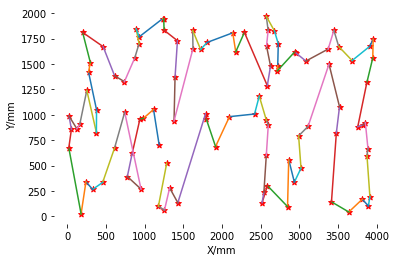

In [6]:
import numpy as np
from matplotlib import pyplot as plt

pop = np.loadtxt("../TSPlib/bestleader.txt")
tsp_ga.DrawPath(tsp_ga.city_coordinate, pop, tsp_ga.N)